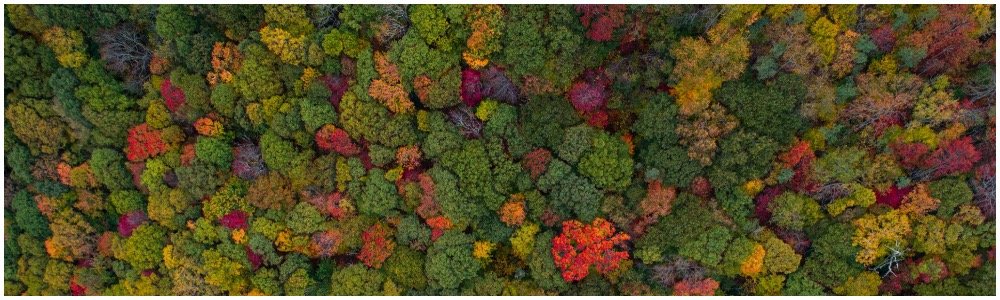

# Instructions

## Programming project: forest cover classification

In this project, you have to predict the class of forest cover (the predominant kind of tree cover) from strictly cartographic and environment variables.

The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains categorical data for qualitative independent variables (wilderness areas and soil types).

You have further details on the data at *covertype.info* file and at https://archive.ics.uci.edu/ml/datasets/Covertype

Be aware that the final dataset has been slighly modified from the original source data.

As performance metric, you can use *AUC* in the binary classification case. For multi-class classification, check as well the confussion matrix and estimate the misclassification probabilities of different classes(check *metrics.confusion_matrix* and *metrics.classification_report* in *sklearn*).

+ Using *MultiClass_Train.csv* file build a predictive model for *Cover_Type* .
+ Try a first a binary classification to predict class #7 (Krummholz, https://en.wikipedia.org/wiki/Krummholz), which is a rare valuable habitat. After that, then try multi-variate classification to predict all classes.
+ For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence have prepared also the necessary script to compute the accuracy estimate on the test data once released.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Create *dummy variables* for relevant categorical features
3. Reformat the Class_type variable into a binary one, being class #7 the target variable versus the others.
4. *Build* an initial binary model for class #7 versus the other ones and test it on the same input data. 
5. Assess expected accuracy using *cross-validation*
6. Report which variable impacts more on results 
7. Try to improve it using methods to tackle class imbalance.
8. Repeat 4., 5., 6. and 7. now with a multi-class model (EXTENDED PROJECT)
9. Produce .csv for kaggle testing 


## Main criteria for grading
From more to less important (the weighting of these components will vary between the in-class and extended projects):
+ Code runs
+ Data preparation
+ Logistic Regression Models(s) have been used
+ Cover Type prediction made
+ Accuracy of predictions for test set (kaggle)
+ Class imbalance management
+ Hyperparameter optimization

# **0. Load Libraries and Data**

*Note* *to* *self*: See [here](https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab) for how to import .py-files into Google Colab with own functions.

In [1]:
#Step 0: Load data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/CML1_Projects/Project2_LinearClassification')

In [42]:
# Step 0: Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict as cvp

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

Custom functions:

In [4]:
# Set print options (show narrays as decimals, not scientific)
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

# Jack's confusion matrix plotter
def plot_confusion_matrix(cm, class_labels):
    """Pretty prints a confusion matrix as a figure

    Args:
        cm:  A confusion matrix for example
        [[245, 5 ], 
         [ 34, 245]]
         
        class_labels: The list of class labels to be plotted on x-y axis

    Rerturns:
        Just plots the confusion matrix.
    """
    
    df_cm = pd.DataFrame(cm, index = [i for i in class_labels],
                  columns = [i for i in class_labels])
    sns.set(font_scale=1)
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel("Predicted label")
    plt.ylabel("Real label")
    plt.show()


## the correction factor: 
def reweight(pi,q1=0.5,r1=0.5):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

# **1. Exploratory Data Analysis**

NB: See also here for guide to EDA for logit: [http://www.jeremy-oakley.staff.shef.ac.uk/mas61004/EDAtutorial/eda-for-logistic-regression.html](http://www.jeremy-oakley.staff.shef.ac.uk/mas61004/EDAtutorial/eda-for-logistic-regression.html).

In [5]:
# Step 1: Read  data
df_train = pd.read_csv('Data/MultiClass_Train.csv', index_col = 0)
print(df_train.columns)
df_train

Index(['Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints',
       'Cover_Type', 'Wilderness_Area', 'Soil_Type'],
      dtype='object')


,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Cover_Type,Wilderness_Area,Soil_Type
Index,,,,,,,,,,,,,
0,3202,34,10,0,0,2760,219,218,134,1734,1,3,38
1,3113,251,13,192,40,5600,191,249,195,2555,2,1,22
2,2801,77,9,510,17,1728,232,223,122,1087,2,1,12
3,3165,82,9,319,56,4890,233,225,124,1452,1,1,29
4,3048,333,11,124,31,2823,196,226,170,666,1,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61001,3255,1,13,0,0,1552,201,215,151,713,1,1,38
61002,3170,170,25,417,61,2605,229,241,128,3350,2,3,33
61003,2994,170,13,134,18,1610,229,245,146,2394,2,3,33


In [6]:
df_test = pd.read_csv('Data/MultiClass_Test.csv', index_col = 0)
print(df_test.columns)
df_test

Index(['Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints',
       'Wilderness_Area', 'Soil_Type'],
      dtype='object')


,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Wilderness_Area,Soil_Type
Index,,,,,,,,,,,,
61006,3111,72,13,283,76,630,235,214,109,499,3,31
61007,2768,0,20,134,26,912,186,198,146,1974,3,10
61008,3360,272,13,685,178,4502,185,244,198,2642,3,39
61009,2413,0,3,201,18,560,215,233,156,866,3,2
61010,2815,54,11,42,9,2313,226,217,123,2866,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...
74074,3053,181,12,150,-13,2162,224,248,155,3827,1,23
74075,2940,218,27,30,4,1433,179,253,197,2616,3,13
74076,3014,208,4,283,37,4716,217,243,162,108,1,29


In [7]:
# Column(s) in train but not in test dataset
df_train.columns.difference(df_test.columns)

Index(['Cover_Type'], dtype='object')

In [8]:
df_train['Cover_Type'].value_counts()

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64

1         AxesSubplot(0.1,0.679412;0.235294x0.220588)
2    AxesSubplot(0.382353,0.679412;0.235294x0.220588)
3    AxesSubplot(0.664706,0.679412;0.235294x0.220588)
4         AxesSubplot(0.1,0.414706;0.235294x0.220588)
5    AxesSubplot(0.382353,0.414706;0.235294x0.220588)
6    AxesSubplot(0.664706,0.414706;0.235294x0.220588)
7             AxesSubplot(0.1,0.15;0.235294x0.220588)
dtype: object

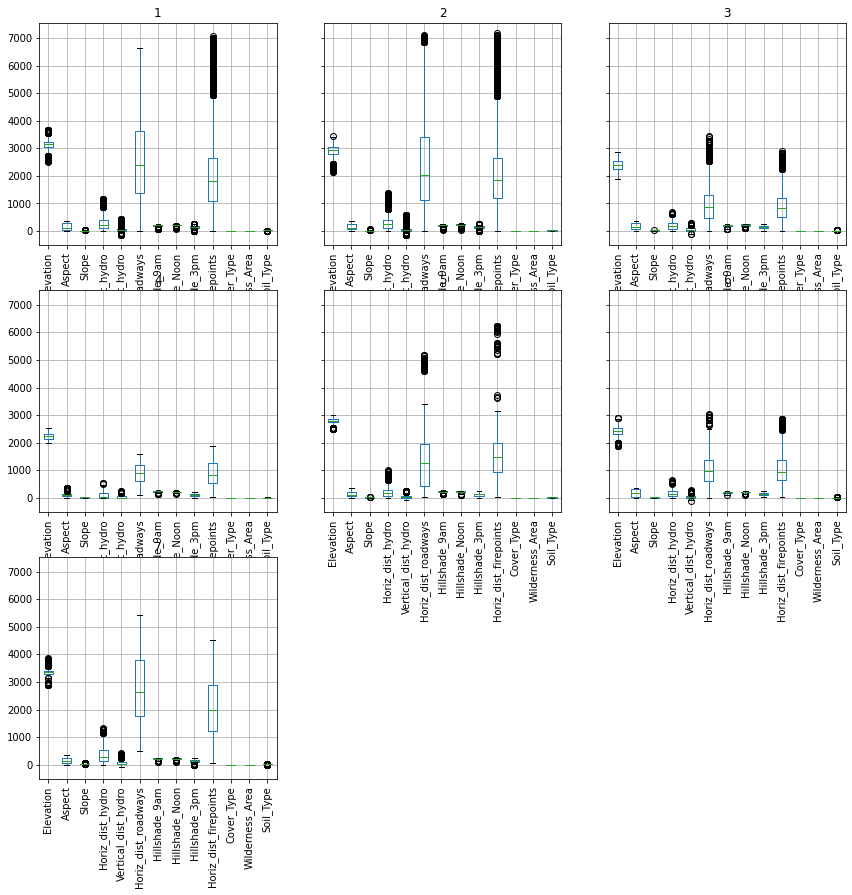

In [9]:
df_train.groupby('Cover_Type').boxplot(rot=90, figsize = [14,14])

There seems to be variation in the distribution of featuers for different categories of $Cover\_Type$. This is revisited again for the constructed target variable of $Cover\_Type == 7$.

In [10]:
#Check for missing values
print(df_train.isnull().sum())
print("\n")
print(df_test.isnull().sum())

Elevation                0
Aspect                   0
Slope                    0
Horiz_dist_hydro         0
Vertical_dist_hydro      0
Horiz_dist_roadways      0
Hillshade_9am            0
Hillshade_Noon           0
Hillshade_3pm            0
Horiz_dist_firepoints    0
Cover_Type               0
Wilderness_Area          0
Soil_Type                0
dtype: int64


Elevation                0
Aspect                   0
Slope                    0
Horiz_dist_hydro         0
Vertical_dist_hydro      0
Horiz_dist_roadways      0
Hillshade_9am            0
Hillshade_Noon           0
Hillshade_3pm            0
Horiz_dist_firepoints    0
Wilderness_Area          0
Soil_Type                0
dtype: int64


# **2. Preprocessing Data**

## 2.1. Create Dummies for Relevant Features

Step 2: I only make dummies for "Wilderness_Area" (and not "Soil_Type") as Kaggle submissions shows this is a better fit. I presume this might be due to loss of degrees of freedom with dummies for "Soil_Type" as we get around 40 dummies here.

In [11]:
# Step 2: Create dummies for relevant features
df_train_dumm = pd.get_dummies(df_train, prefix=['wild_area'], columns=['Wilderness_Area'], drop_first = True)
df_train_dumm = pd.get_dummies(df_train_dumm, prefix=['soil_'], columns=['Soil_Type'], drop_first = True)
df_train_dumm.head(10)

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Cover_Type,wild_area_2,wild_area_3,wild_area_4,soil__2,soil__3,soil__4,soil__5,soil__6,soil__7,soil__8,soil__9,soil__10,soil__11,soil__12,soil__13,soil__14,soil__16,soil__17,soil__18,soil__19,soil__20,soil__21,soil__22,soil__23,soil__24,soil__25,soil__26,soil__27,soil__28,soil__29,soil__30,soil__31,soil__32,soil__33,soil__34,soil__35,soil__36,soil__37,soil__38,soil__39,soil__40
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3202,34,10,0,0,2760,219,218,134,1734,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,3113,251,13,192,40,5600,191,249,195,2555,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2801,77,9,510,17,1728,232,223,122,1087,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3165,82,9,319,56,4890,233,225,124,1452,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,3048,333,11,124,31,2823,196,226,170,666,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2347,31,16,242,140,216,214,203,120,1425,3,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,3381,56,22,376,147,1919,228,187,81,2059,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,2290,86,24,30,0,1325,246,192,61,830,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,3051,75,21,150,0,1003,240,194,74,1733,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
df_test_dumm = pd.get_dummies(df_test, prefix=['wild_area'], columns=['Wilderness_Area'], drop_first = True)
df_test_dumm = pd.get_dummies(df_test_dumm, prefix=['soil_'], columns=['Soil_Type'], drop_first = True)
df_test_dumm.head(10)

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,wild_area_2,wild_area_3,wild_area_4,soil__2,soil__3,soil__4,soil__5,soil__6,soil__7,soil__8,soil__9,soil__10,soil__11,soil__12,soil__13,soil__14,soil__16,soil__17,soil__18,soil__19,soil__20,soil__21,soil__22,soil__23,soil__24,soil__25,soil__26,soil__27,soil__28,soil__29,soil__30,soil__31,soil__32,soil__33,soil__34,soil__35,soil__36,soil__37,soil__38,soil__39,soil__40
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
61006,3111,72,13,283,76,630,235,214,109,499,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
61007,2768,0,20,134,26,912,186,198,146,1974,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61008,3360,272,13,685,178,4502,185,244,198,2642,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
61009,2413,0,3,201,18,560,215,233,156,866,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61010,2815,54,11,42,9,2313,226,217,123,2866,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
61011,2657,58,22,90,51,2521,230,187,79,2391,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61012,2182,310,37,295,160,408,98,187,216,175,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61013,3345,210,13,816,143,2873,209,252,176,1226,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
61014,2868,12,10,127,24,4608,210,220,146,4774,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 2.2. Standardize Data

Because Logistic Regression with an L2 penalty term is used the data should be standardized in order for the penalty to be equivalent across features with different scales

In [13]:
filter_col = [col for col in df_train_dumm if col.startswith('soil_')]

In [14]:
from sklearn import preprocessing

# Instantiate scaler
scaler = preprocessing.StandardScaler()

# Divide datasets
features_train = filter_col + ['wild_area_2', 'wild_area_3', 'wild_area_4', 'Cover_Type']
train_dummies = df_train_dumm[features_train]
train_to_scl = df_train_dumm.drop(features_train, axis = 1)

del features_train[-1]
test_dummies = df_test_dumm[features_train]
test_to_scl = df_test_dumm.drop(features_train, axis = 1)


# Fit to training set
scaler.fit(train_to_scl)


###########   TRAIN DATA
# Transform training and testing data based on values of training set (no refit to test data, just transforming):
df_train_scl = scaler.transform(train_to_scl)
df_train_scl = pd.DataFrame(df_train_scl, columns = train_to_scl.columns, index = train_to_scl.index)
df_train_scl = pd.concat([df_train_scl, train_dummies], axis = 1)
df_train_scl

###########   TEST DATA
df_test_scl = scaler.transform(test_to_scl)
df_test_scl = pd.DataFrame(df_test_scl, columns = test_to_scl.columns, index = test_to_scl.index)
df_test_scl = pd.concat([df_test_scl, test_dummies], axis = 1)
df_test_scl

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,soil__2,soil__3,soil__4,soil__5,soil__6,soil__7,soil__8,soil__9,soil__10,soil__11,soil__12,soil__13,soil__14,soil__16,soil__17,soil__18,soil__19,soil__20,soil__21,soil__22,soil__23,soil__24,soil__25,soil__26,soil__27,soil__28,soil__29,soil__30,soil__31,soil__32,soil__33,soil__34,soil__35,soil__36,soil__37,soil__38,soil__39,soil__40,wild_area_2,wild_area_3,wild_area_4
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
61006,0.545709,-0.750909,-0.152141,0.066669,0.503118,-1.102917,0.854629,-0.460602,-0.876299,-1.124175,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
61007,-0.675142,-1.392540,0.776076,-0.636026,-0.353048,-0.922167,-0.958176,-1.264233,0.087632,-0.004190,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
61008,1.431982,1.031401,-0.152141,1.962530,2.249696,1.378873,-0.995172,1.046206,1.442346,0.503030,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
61009,-1.938704,-1.392540,-1.478165,-0.320049,-0.490034,-1.147784,0.114709,0.493709,0.348154,-0.845508,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
61010,-0.507853,-0.911317,-0.417346,-1.069904,-0.644144,-0.024184,0.521665,-0.309922,-0.511569,0.673116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74074,0.339267,0.220450,-0.284743,-0.560569,-1.020857,-0.120969,0.447673,1.247114,0.322102,1.402814,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
74075,-0.062937,0.550178,1.704293,-1.126497,-0.729761,-0.588227,-1.217148,1.498248,1.416294,0.483288,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
74076,0.200454,0.461062,-1.345563,0.066669,-0.164691,1.516038,0.188701,0.995979,0.504467,-1.421066,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 2.3. Create Binary Class Target (class #7 is the target to predict)

In [15]:
# Step 3: Reformat the data to have an binary class target (class #7 is the target to predict)
df_train_scl_multi = df_train_scl.copy()

df_train_scl['Cover_Type_new'] = [1 if q == 7 else 0 for q in df_train_scl['Cover_Type'] ]
df_train_scl = df_train_scl.drop('Cover_Type', axis = 1)
df_train_scl['Cover_Type_new'].value_counts()

0    58843
1     2163
Name: Cover_Type_new, dtype: int64

So we seem to have class imbalance as only roughly 3.5% are class #7

0         AxesSubplot(0.1,0.15;0.363636x0.75)
1    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

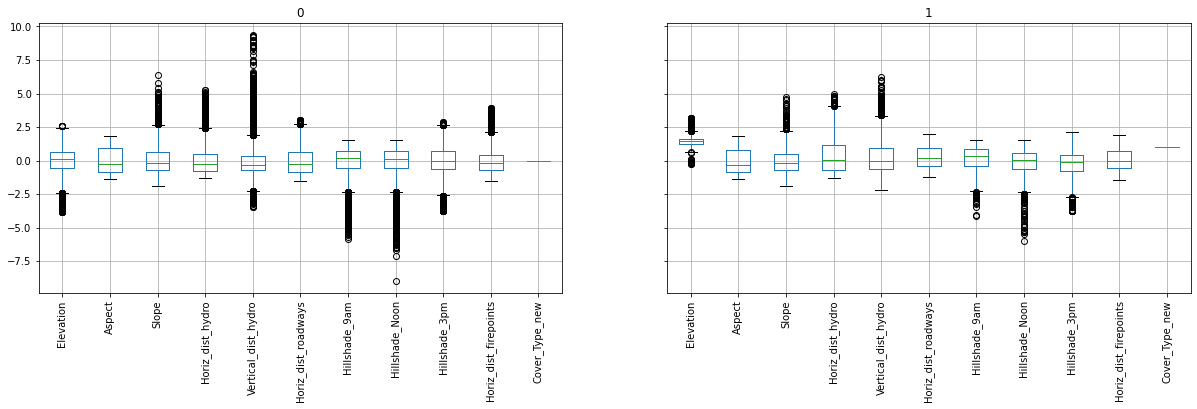

In [16]:
# Revisit distribution of features for binary target
df_train_scl.drop(features_train, axis = 1).groupby('Cover_Type_new').boxplot(rot=90, figsize = [20,5])

Means appear to similarly distributed for both $Cover\_Type==7$ and $Cover\_Type \neq 7$. (Not so surprising, now that everything is standardized.)

# **3. Logistic Regression – Baseline**

## 5.1. Fit Logistic Model to Predict Class #7

In [18]:
# Step 4: Build a binary model to predict class #7
F = df_train_scl.drop('Cover_Type_new', axis = 1)
y = df_train_scl['Cover_Type_new']

# To report stats
feature_names = F.columns
class_labels = ['Not Krummholz', 'Krummholz']

In [ ]:
#Instantiate logistic regression
logit_base = LogisticRegression(penalty='l2', C=100.0, 
                           fit_intercept=True, 
                           solver='liblinear', max_iter=500)

#Fit
logit_base.fit(F,y)

#Predicted classes
p_hat = logit_base.predict(F)

#Predicted probabilities
p_hat_proba = logit_base.predict_proba(F)
p_hat_proba = p_hat_proba[:,1]
print(p_hat_proba)

[0.32 0.00 0.00 ... 0.01 0.00 0.00]


## 5.2. Accuracy Assessment (in-sample)

### 5.2.1. AUC Metric and Plot

In [ ]:
# AUC metric

fpr, tpr, thresholds = metrics.roc_curve(y, p_hat_proba)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.9675222018386623


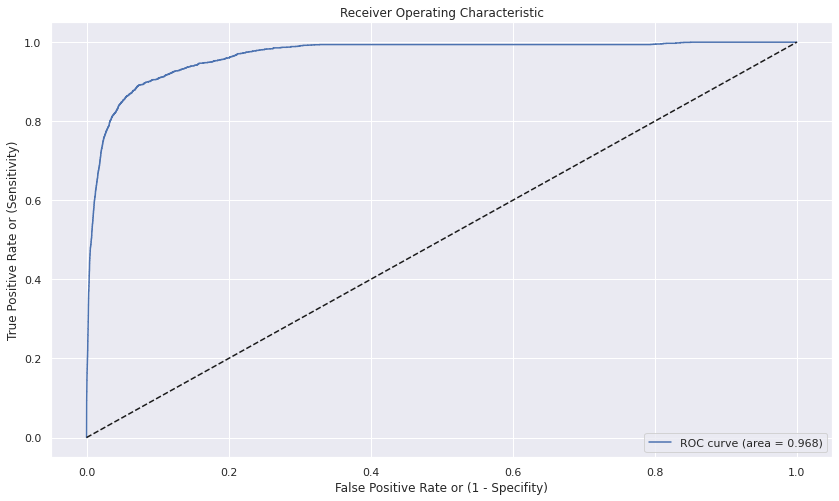

In [ ]:
#AUC/ROC plot

#Create plot
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)

# Refining plot
plt.plot([0, 1], [0, 1], 'k--') 
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.legend(loc="lower right")

# figure size
fig = plt.gcf()
fig.set_size_inches(14, 8)
plt.show()

#Inspect figure
plt.show()

The curve looks pretty nice.

### 5.2.2. Confusion Matrix

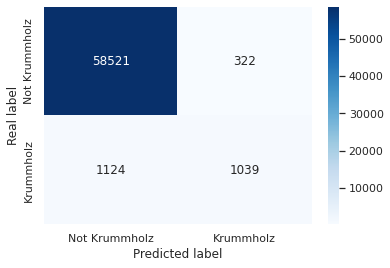

In [ ]:
# Plot confusion matrix
cm2 = confusion_matrix(y_pred=p_hat, y_true=y, labels=[0,1] )
plot_confusion_matrix(cm2, class_labels) 

### 5.2.3 Feature Impact

In [ ]:
# Step 6: Report variable impact
print(abs(logit_base.coef_))

[[4.05 0.08 0.32 0.43 0.19 0.00 0.30 0.09 0.82 0.39 1.66 0.27 1.77 1.29]]


Note to self: See also [https://sefiks.com/2021/01/06/feature-importance-in-logistic-regression/](https://sefiks.com/2021/01/06/feature-importance-in-logistic-regression/) for one way of calculating feature importance for logistic regression.

## 5.3 Accuracy Assessment (out-of-sample)

### 5.3.1. Cross-Validated AUC Metric and Plot

In [ ]:
# Note to self: 'cvp' is alias for sklearn.model_selection.cross_val_predict
y_hat_cv_proba = cvp(logit_base, F, y, cv=100, method='predict_proba') #Runtime = 1 min 53s
print(y_hat_cv_proba)

[[0.68 0.32]
 [1.00 0.00]
 [1.00 0.00]
 ...
 [0.99 0.01]
 [1.00 0.00]
 [1.00 0.00]]


In [ ]:
# Cross-validated AUC metric
y_hat_cv_proba_preds = y_hat_cv_proba[:,1]

fpr_cv, tpr_cv, thresholds_cv = metrics.roc_curve(y, y_hat_cv_proba_preds)
roc_auc_cv = metrics.auc(fpr_cv, tpr_cv)
print(roc_auc_cv)

0.9672877218925788


Difference between cross-validated and not-cross-validated AUC scores are not very different from each other.

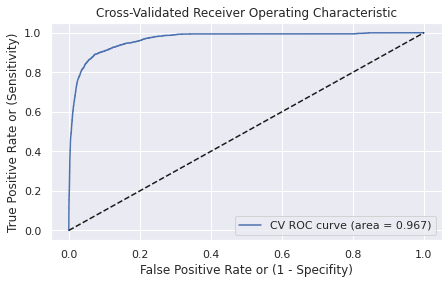

In [ ]:
#Cross-validated AUC/ROC plot

#Create plot
plt.plot(fpr_cv, tpr_cv, label='CV ROC curve (area = %0.3f)' % roc_auc_cv)

# Refining plot
plt.plot([0, 1], [0, 1], 'k--') 
plt.title('Cross-Validated Receiver Operating Characteristic')
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.legend(loc="lower right")

# figure size
fig = plt.gcf()
fig.set_size_inches(7, 4)
plt.show()

#Inspect figure
plt.show()

### 5.3.2. Cross-Validated Confusion Matrix

In [ ]:
y_hat_cv = cvp(logit_base, F, y, cv=100) #Runtime = 1 min 47s

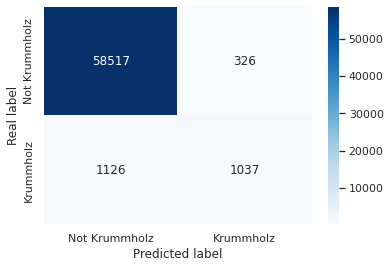

In [ ]:
# Plot confusion matrix
cm1 = confusion_matrix(y_pred=y_hat_cv, y_true=y, labels=[0,1] )
plot_confusion_matrix(cm1, class_labels) 

Difference between cross-validated confusion matrix and not-cross-validated confusion matrix are not very different from each other.

# **4. Logistic Regression – Oversampling**

## 6.1. Fit Logistic Model with Oversampled Data

In [549]:
ros = RandomOverSampler(random_state=0)

In [ ]:
F_resampled, y_resampled = ros.fit_resample(F, y)

In [ ]:
#Instantiate logistic regression on resampled data
logit_imb = LogisticRegression(C=100, 
                                     solver='liblinear')

# Fit
logit_imb.fit(F_resampled,y_resampled)

# Predict classes
p_hat_imb = logit_imb.predict(F)

#Predicted probabilities
p_hat_imb_proba = logit_imb.predict_proba(F)
p_hat_imb_proba = p_hat_imb_proba[:,1]
print(p_hat_imb_proba)

[0.73 0.03 0.00 ... 0.04 0.00 0.00]


In [ ]:
# Add predicted probabilities to original dataset (as in Jack's notebook)
df_train_dumm["pred_prob"] = p_hat_proba
df_train_dumm["pred_prob_imb"] = p_hat_imb_proba

In [ ]:
# Set parameters for correction function
q1 = y.sum()/len(y)
r1 = y_resampled.sum()/len(y_resampled)

# correcting ''imb'' predictions for biased sample
df_train_dumm["pred_prob_imb_corr"] = df_train_dumm["pred_prob_imb"].apply(reweight,args=(q1,r1))
df_train_dumm

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Cover_Type,Soil_Type,wild_area_2,wild_area_3,wild_area_4,pred_prob,pred_prob_imb,pred_prob_imb_corr
Index,,,,,,,,,,,,,,,,,,
0,3202,34,10,0,0,2760,219,218,134,1734,1,38,0,1,0,3.160348e-01,7.297058e-01,9.027790e-02
1,3113,251,13,192,40,5600,191,249,195,2555,2,22,0,0,0,4.411054e-04,2.674143e-02,1.008973e-03
2,2801,77,9,510,17,1728,232,223,122,1087,2,12,0,0,0,8.990724e-07,3.869049e-05,1.422270e-06
3,3165,82,9,319,56,4890,233,225,124,1452,1,29,0,0,0,4.535317e-03,1.472167e-01,6.305695e-03
4,3048,333,11,124,31,2823,196,226,170,666,1,23,0,0,0,2.331265e-04,9.866082e-03,3.661453e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61001,3255,1,13,0,0,1552,201,215,151,713,1,38,0,0,0,8.235428e-02,7.857036e-01,1.187671e-01
61002,3170,170,25,417,61,2605,229,241,128,3350,2,33,0,1,0,4.320457e-02,4.715834e-01,3.176327e-02
61003,2994,170,13,134,18,1610,229,245,146,2394,2,33,0,1,0,6.360108e-03,3.663548e-02,1.395939e-03


## 6.2. Accuracy Assessment for Model with Class Imbalance (in-sample) 

In [ ]:
# AUC metric

fpr_imb, tpr_imb, thresholds_imb = metrics.roc_curve(y, df_train_dumm["pred_prob_imb_corr"])
roc_auc_imb = metrics.auc(fpr_imb, tpr_imb)
print(roc_auc_imb)

0.9699318439142646


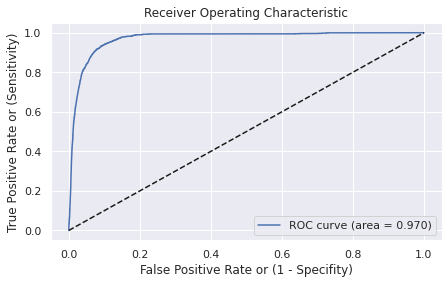

In [ ]:
#AUC/ROC plot

#Create plot
plt.plot(fpr_imb, tpr_imb, label='ROC curve (area = %0.3f)' % roc_auc_imb)

# Refining plot
plt.plot([0, 1], [0, 1], 'k--') 
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.legend(loc="lower right")

# figure size
fig = plt.gcf()
fig.set_size_inches(7, 4)
plt.show()

#Inspect figure
plt.show()

## 6.3. Accuracy Assessment for Model with Class Imbalance (out-of-sample) 

In [ ]:
# Note to self: 'cvp' is alias for sklearn.model_selection.cross_val_predict
y_hat_imb_cv_proba = cvp(logit_imb, F, y, cv=100, method='predict_proba') #Runtime = 2m 1s
print(y_hat_imb_cv_proba)

[[0.68 0.32]
 [1.00 0.00]
 [1.00 0.00]
 ...
 [0.99 0.01]
 [1.00 0.00]
 [1.00 0.00]]


In [ ]:
# Cross-validated AUC metric
y_hat_imb_cv_proba_preds = y_hat_imb_cv_proba[:,1]

fpr_imb_cv, tpr_imb_cv, thresholds_imb_cv = metrics.roc_curve(y, y_hat_imb_cv_proba_preds)
roc_auc_imb_cv = metrics.auc(fpr_imb_cv, tpr_imb_cv)
print(roc_auc_imb_cv)

0.9672877218925788


# **5. Logistic Regression – Undersampling**

Got almost exact same Kaggle score (but a little worse) than oversampling. So this is left for now.

## 7.1. Fit Logistic Model with Undersampled Data

In [ ]:
rus = RandomUnderSampler(random_state=0)

In [ ]:
F_undersmp, y_undersmp = rus.fit_resample(F, y)

In [ ]:
#Instantiate logistic regression on resampled data
logit_under = LogisticRegression(C=100, 
                                     solver='liblinear')

# Fit
logit_under.fit(F_undersmp,y_undersmp)

# Predict classes
p_hat_under = logit_under.predict(F)

#Predicted probabilities
p_hat_under_proba = logit_under.predict_proba(F)
p_hat_under_proba = p_hat_under_proba[:,1]
print(p_hat_under_proba)

[0.75 0.03 0.00 ... 0.04 0.00 0.00]


In [ ]:
# Add predicted probabilities to original dataset (as in Jack's notebook)
df_train_dumm["pred_prob"] = p_hat_proba
df_train_dumm["pred_prob_under"] = p_hat_under_proba

In [ ]:
# Set parameters for correction function
q1 = y.sum()/len(y)
r1 = y_resampled.sum()/len(y_resampled)

# correcting ''imb'' predictions for biased sample
df_train_dumm["pred_prob_under_corr"] = df_train_dumm["pred_prob_under"].apply(reweight,args=(q1,r1))
df_train_dumm

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Cover_Type,Soil_Type,wild_area_2,wild_area_3,wild_area_4,pred_prob,pred_prob_imb,pred_prob_imb_corr,pred_prob_under,pred_prob_under_corr
Index,,,,,,,,,,,,,,,,,,,,
0,3202,34,10,0,0,2760,219,218,134,1734,1,38,0,1,0,3.160348e-01,7.297058e-01,9.027790e-02,7.530597e-01,1.007989e-01
1,3113,251,13,192,40,5600,191,249,195,2555,2,22,0,0,0,4.411054e-04,2.674143e-02,1.008973e-03,2.837268e-02,1.072251e-03
2,2801,77,9,510,17,1728,232,223,122,1087,2,12,0,0,0,8.990724e-07,3.869049e-05,1.422270e-06,4.626417e-05,1.700693e-06
3,3165,82,9,319,56,4890,233,225,124,1452,1,29,0,0,0,4.535317e-03,1.472167e-01,6.305695e-03,1.702533e-01,7.485976e-03
4,3048,333,11,124,31,2823,196,226,170,666,1,23,0,0,0,2.331265e-04,9.866082e-03,3.661453e-04,1.019146e-02,3.783403e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61001,3255,1,13,0,0,1552,201,215,151,713,1,38,0,0,0,8.235428e-02,7.857036e-01,1.187671e-01,7.584012e-01,1.034521e-01
61002,3170,170,25,417,61,2605,229,241,128,3350,2,33,0,1,0,4.320457e-02,4.715834e-01,3.176327e-02,4.552565e-01,2.980471e-02
61003,2994,170,13,134,18,1610,229,245,146,2394,2,33,0,1,0,6.360108e-03,3.663548e-02,1.395939e-03,3.817193e-02,1.456717e-03


## 7.2. Accuracy Assessment for Undersampled Model (in-sample) 

In [ ]:
# AUC metric

fpr_under, tpr_under, thresholds_under = metrics.roc_curve(y, df_train_dumm["pred_prob_under_corr"])
roc_auc_under = metrics.auc(fpr_under, tpr_under)
print(roc_auc_under)

0.9698861484523149


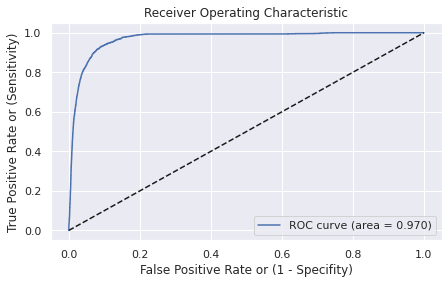

In [ ]:
#AUC/ROC plot

#Create plot
plt.plot(fpr_under, tpr_under, label='ROC curve (area = %0.3f)' % roc_auc_under)

# Refining plot
plt.plot([0, 1], [0, 1], 'k--') 
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.legend(loc="lower right")

# figure size
fig = plt.gcf()
fig.set_size_inches(7, 4)
plt.show()

#Inspect figure
plt.show()

# **6. Hyperparameter Optimization**

In [51]:
from sklearn.pipeline import Pipeline
from sklearn import decomposition

# Instantiate logistic reg, scaler and also PCA (to reduce dimensionality)
std_slc = preprocessing.StandardScaler()
pca = decomposition.PCA()
log_reg = LogisticRegression(solver = 'liblinear')

# Create pipeline
pipe = Pipeline(steps=[('std_slc', std_slc), 
                       ('pca', pca), 
                       ('logistic_Reg', log_reg)])

# Creating Parameter Space
n_components = list(range(1,F_resampled.shape[1]+1,1))
C = np.logspace(-4, 4, 20)
#C = np.logspace(-4, 4, 50) --> too computationally intensive
penalty = ['l1', 'l2']

parameters = dict(pca__n_components=n_components, 
                  logistic_Reg__C=C, 
                  logistic_Reg__penalty=penalty)

In [52]:
C

array([0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.03, 0.09, 0.23, 0.62, 1.62,
       4.28, 11.29, 29.76, 78.48, 206.91, 545.56, 1438.45, 3792.69,
       10000.00])

In [53]:
# No. of cores in Colab:
import multiprocessing
n_cpus = multiprocessing.cpu_count()
n_cpus

2

In [ ]:
#%%script echo skipping 
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(pipe, parameters, n_jobs = n_cpus, verbose = 2)

# Fitting the grid search
clf.fit(F_resampled, y_resampled) #Run time: 38m 45s min

# Viewing The Best Parameters
print('Best Penalty:', clf.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf.best_estimator_.get_params()['logistic_Reg__C'])
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['logistic_Reg'])

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best Penalty: l1
Best C: 0.2682695795279725
Best Number Of Components: 12

LogisticRegression(C=0.2682695795279725, penalty='l1', solver='liblinear')


# **7. Logistic Regression – Oversampling and Optimal Hyperparameters**

## 9.1. Fit Logistic Model with Oversampled Data

In [25]:
ros = RandomOverSampler(random_state=0)

In [27]:
F_resampled, y_resampled = ros.fit_resample(F, y)

In [46]:
#Instantiate logistic regression on resampled data
                                #C=100 
logit_opt = LogisticRegression(C=0.2682695795279725, 
                               class_weight='balanced',
                               penalty='l2', 
                               solver='liblinear')

# Fit
logit_opt.fit(F,y)

# Predict classes
p_hat_opt = logit_opt.predict(F)

#Predicted probabilities
p_hat_opt_proba = logit_opt.predict_proba(F)
p_hat_opt_proba = p_hat_opt_proba[:,1]
print(p_hat_opt_proba)

[0.94 0.01 0.00 ... 0.01 0.00 0.00]


In [47]:
# Add predicted probabilities to original dataset (as in Jack's notebook)
df_train_dumm["pred_prob"] = p_hat_opt
df_train_dumm["pred_prob_opt"] = p_hat_opt_proba

In [48]:
# Set parameters for correction function
q1 = y.sum()/len(y)
r1 = y_resampled.sum()/len(y_resampled)

# correcting ''imb'' predictions for biased sample
df_train_dumm["pred_prob_opt_corr"] = df_train_dumm["pred_prob_opt"].apply(reweight,args=(q1,r1))
df_train_dumm

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Cover_Type,wild_area_2,wild_area_3,wild_area_4,soil__2,soil__3,soil__4,soil__5,soil__6,soil__7,soil__8,soil__9,soil__10,soil__11,soil__12,soil__13,soil__14,soil__16,soil__17,soil__18,soil__19,soil__20,soil__21,soil__22,soil__23,soil__24,soil__25,soil__26,soil__27,soil__28,soil__29,soil__30,soil__31,soil__32,soil__33,soil__34,soil__35,soil__36,soil__37,soil__38,soil__39,soil__40,pred_prob,pred_prob_opt,pred_prob_opt_corr
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3202,34,10,0,0,2760,219,218,134,1734,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.936032,3.497573e-01
1,3113,251,13,192,40,5600,191,249,195,2555,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.005346,1.975421e-04
2,2801,77,9,510,17,1728,232,223,122,1087,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000048,1.772120e-06
3,3165,82,9,319,56,4890,233,225,124,1452,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.129343,5.431154e-03
4,3048,333,11,124,31,2823,196,226,170,666,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.005270,1.947226e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61001,3255,1,13,0,0,1552,201,215,151,713,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.852039,1.746974e-01
61002,3170,170,25,417,61,2605,229,241,128,3350,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.169261,7.433823e-03
61003,2994,170,13,134,18,1610,229,245,146,2394,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.007381,2.732439e-04


## 9.2. Accuracy Assessment for Model with Class Imbalance (in-sample) 

In [49]:
# AUC metric

fpr_opt, tpr_opt, thresholds_opt = metrics.roc_curve(y, df_train_dumm["pred_prob_opt_corr"])
roc_auc_opt = metrics.auc(fpr_opt, tpr_opt)
print(roc_auc_opt)

0.9790902248803633


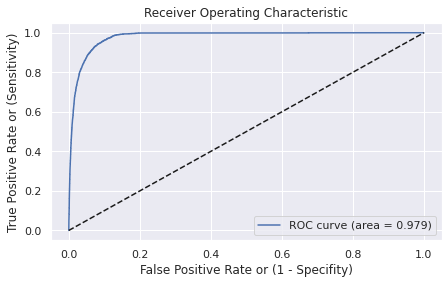

In [557]:
#AUC/ROC plot

#Create plot
plt.plot(fpr_opt, tpr_opt, label='ROC curve (area = %0.3f)' % roc_auc_opt)

# Refining plot
plt.plot([0, 1], [0, 1], 'k--') 
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.legend(loc="lower right")

# figure size
fig = plt.gcf()
fig.set_size_inches(7, 4)
plt.show()

#Inspect figure
plt.show()

## 9.3. Accuracy Assessment for Model with Class Imbalance (out-of-sample) 

In [ ]:
# Note to self: 'cvp' is alias for sklearn.model_selection.cross_val_predict
y_hat_opt_cv_proba = cvp(logit_opt, F, y, cv=100, method='predict_proba') #Runtime = 2m 1s
print(y_hat_opt_cv_proba)

In [ ]:
# Cross-validated AUC metric
y_hat_opt_cv_proba_preds = y_hat_opt_cv_proba[:,1]

fpr_opt_cv, tpr_opt_cv, thresholds_opt_cv = metrics.roc_curve(y, y_hat_opt_cv_proba_preds)
roc_auc_opt_cv = metrics.auc(fpr_opt_cv, tpr_opt_cv)
print(roc_auc_opt_cv)

# **8. Multiclass Classification Model**

In [34]:
# Training data set without binary Cover_type
df_train_scl_multi

# Step 4: Build a model to predict multiclasses
F_multi = df_train_scl_multi.drop('Cover_Type', axis = 1)
y_multi = df_train_scl_multi['Cover_Type']

# To report stats
feature_names = F_multi.columns
class_labels_multi = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']

## 8.1. Fit Multiclass Model

In [22]:
y_multi.value_counts()

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64

In [38]:
#Instantiate logistic regression
logit_multi = LogisticRegression(penalty='l2', C=100.0, 
                           fit_intercept=True, 
                           multi_class = 'multinomial',
                           solver= 'lbfgs', 
                           max_iter=500)

#Fit
logit_multi.fit(F_multi,y_multi)

#Predicted classes
p_hat_multi = logit_multi.predict(F_multi)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [33]:
y_multi.value_counts()

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64

In [31]:
p_hat_multi_df = pd.DataFrame(p_hat_multi)
p_hat_multi_df.value_counts()

2    31766
1    21778
3     4543
7     1687
6      994
4      191
5       47
dtype: int64

## 8.2. Assessing Multiclass Accuracy

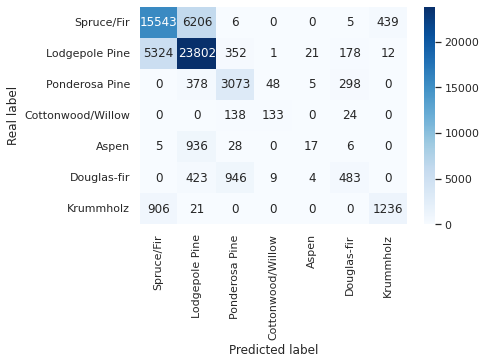

In [37]:
# Confusion Matrix 
cm_multi =  confusion_matrix(y_pred=p_hat_multi, 
                             y_true=y_multi, 
                             labels=[1,2,3,4,5,6,7])
plot_confusion_matrix(cm_multi, class_labels_multi)

In [46]:
# Classification Report
print(classification_report(y_true = y_multi, y_pred = p_hat_multi))

              precision    recall  f1-score   support

           1       0.71      0.70      0.71     22199
           2       0.75      0.80      0.77     29690
           3       0.68      0.81      0.74      3802
           4       0.70      0.45      0.55       295
           5       0.36      0.02      0.03       992
           6       0.49      0.26      0.34      1865
           7       0.73      0.57      0.64      2163

    accuracy                           0.73     61006
   macro avg       0.63      0.52      0.54     61006
weighted avg       0.72      0.73      0.72     61006



# _Exporting Binary Predictions for Kaggle Competition

In [558]:
# Dataframe for submission w. imb. predictions
p_hat_opt_proba_test = logit_opt.predict_proba(df_test_scl)
p_hat_opt_proba_test = p_hat_opt_proba_test[:,1]

kaggle = pd.DataFrame(p_hat_opt_proba_test, index = df_test_scl.index).rename(columns={0: "p_hat_opt_proba_test"})
kaggle 

,p_hat_opt_proba_test
Index,
61006,4.730069e-02
61007,2.047461e-04
61008,9.602920e-01
61009,9.950096e-08
61010,5.385797e-04
...,...
74074,2.967043e-02
74075,7.959539e-03
74076,3.014795e-03


In [559]:
# Reweight dataframe w. imb. predictions
kaggle["p_hat_opt_proba_test"] = kaggle["p_hat_opt_proba_test"].apply(reweight,args=(q1,r1))
kaggle

,p_hat_opt_proba_test
Index,
61006,1.821719e-03
61007,7.527711e-06
61008,4.706108e-01
61009,3.657539e-09
61010,1.980784e-05
...,...
74074,1.122738e-03
74075,2.948439e-04
74076,1.111431e-04


In [560]:
# Step 9: Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"Index": kaggle.index, "Cover_Type": kaggle['p_hat_opt_proba_test']})
test_predictions_submit.to_csv("Predictions/pred7_opt_soil-dumms.csv", index = False)

# _Exporting Multiclass Predictions for Kaggle Competition

In [58]:
# Dataframe for submission in multiclass competition
p_hat_multi_test = logit_multi.predict(df_test_scl)

kaggle_multi = pd.DataFrame(p_hat_multi_test, index = df_test_scl.index).rename(columns={0: "p_hat_multi_test"})
kaggle_multi 

,p_hat_multi_test
Index,
61006,1
61007,2
61008,7
61009,3
61010,2
...,...
74074,1
74075,2
74076,2


In [59]:
test_multiclass_predictions_submit = pd.DataFrame({"Index": kaggle_multi.index, "Cover_Type": kaggle_multi['p_hat_multi_test']})
test_multiclass_predictions_submit.to_csv("Predictions/Multi/pred1_naive-first-try.csv", index = False)